# Session 26: Gurobi Practice (Portfolio Optimization) 

In this lab, you will practice your Gurobi coding skills by analyzing a large-scale portfolio optimization case.

## 1. Problem

Trojan investment is exploring new methods for updating its portfolio of US stocks based on mixed integer linear and quadratic optimization. In particular, it would like to optimize the trade-off between returns and risk, given the presence of transaction costs and managerial overhead. In particular, transaction cost implies that the new portfolio must not be too different from the current portfolio. Managerial overhead means that if the company invest in any stock, there should be a sufficiently large stake, and the number of stocks in the portfolio cannot be too large. The abstract formulation is given below.

**Data:**

- $S$: the set of stocks.
- $w_i$: the old weight of stock $i \in S$ before optimization. (The "weight" of a stock is % of total funds invested in the stock; weights of all stocks should add to one.)
- $R_i$: the expected annual return of stock $i \in S$.
- $C_{ij}$: the estimated covariance between stocks $i, j \in S$.
- $\sigma_{target}$: the maximum volatility of the final portfolio.
- $\Delta$: the total movement allowed between the old weights and the new weights.
- $k$: the maximum \# of stocks allowed in the portfolio.
- $\epsilon$: the minimum non-zero weight allowed. 

**Decision variables:** 

- $x_i$: the new weight of stock $i$. (Continuous)
- $\delta_i$: difference in weight for stock $i$. (Continuous)
- $z_i$: whether to use stock $i$. (Binary)

**Objective and constraints:** All summations are over the set $S$ of stocks.

$$\begin{aligned}
\text{Maximize:} && \sum_{i} R_i x_i & && \text{(Average Return)}\\
\text{subject to:} \\
\text{(Valid weights)} && \sum_i x_i & = 1 \\
\text{(Risk tolerance)} && \sum_{i,j} C_{ij}x_ix_j & \le \sigma_{target}^2 \\
\text{(Change in weights 1)} && x_i - w_i &\le \delta_i && \text{for each stock $i$.} \\
\text{(Change in weights 2)} && -(x_i - w_i) &\le \delta_i && \text{for each stock $i$.} \\
\text{(Change in weights 3)} && \frac{1}{2}\sum_i \delta_i &\le \Delta\\
\text{(Non-negligible weights)} && \epsilon z_i \le x_i &\le z_i && \text{for each stock $i$.}\\
\text{(Simplicity)} && \sum_i z_i & \le k \\
\text{(Non-negativity)} && x_i & \ge 0 
\end{aligned}$$


## 2. Data

The file "26-data.xlsx" (available on Github where you downloaded this notebook) contains two sheets. The sheet "s&p500" contains the stock prices of every stock on the S&P500 for 10 years. The sheet "oldPortfolio" contains the weights on the current portfolio. The following code can be used to load the data and calculate the returns $R_i$ and covariances $C_{ij}$. 

In [1]:
import pandas as pd
import numpy as np

oldPortfolio=pd.read_excel('26-data.xlsx',sheet_name='oldPortfolio'\
                           ,index_col=0)['Weight']
oldPortfolio

Stock
AMGN    0.306342
CNC     0.231379
FFIV    0.290586
FL      0.019480
LEG     0.152214
Name: Weight, dtype: float64

In [2]:
rawPrices=pd.read_excel('26-data.xlsx',sheet_name='s&p500'\
                        ,index_col=0).fillna(method='ffill')
logPrices=np.log(rawPrices)
priceChange=logPrices.diff(1).iloc[1:,:].fillna(0)
C=priceChange.cov()*252           # About 252 business days in a year
R=priceChange.mean()*252

In [3]:
R.head()

MMM     0.101382
AOS     0.252184
ABT     0.084367
ABBV    0.096193
ACN     0.141367
dtype: float64

In [4]:
C.iloc[:5,:5]

,MMM,AOS,ABT,ABBV,ACN
MMM,0.049054,0.042544,0.021191,0.008905,0.031119
AOS,0.042544,0.098905,0.025834,0.010012,0.039423
ABT,0.021191,0.025834,0.042142,0.012491,0.023052
ABBV,0.008905,0.010012,0.012491,0.039773,0.008844
ACN,0.031119,0.039423,0.023052,0.008844,0.063869


## 3. Optimizing for Given Parameters

Solve the optimization problem for the following parameters:

- $\sigma_{target}$: 0.25
- $\Delta$: 0.3
- $k$: 20
- $\epsilon$: 0.001

The code should save the result in an excel file "26-output.xlsx" with a single sheet, in the same format as the "oldPortfolio" sheet above.

In [19]:
# Write your formulation here


In [6]:
# Obtain the results here


Return: 0.25668085087449366
Risk: 0.2500017855103704
# stocks: 8.0
Change in portfolio: 0.3


In [23]:
# Display the optimal portfolio here


,Stock,Weight
1,AMGN,0.239860
4,CNC,0.231379
5,FFIV,0.209281
7,NFLX,0.186885
3,AVGO,0.054713
0,ALGN,0.051099
6,FL,0.019480
2,BHF,0.007303


## 4. Tradeoff between multiple objectives

The following example illustrates how to analyze problems with multiple objectives. It is based on Q1 from session 23, or DMD Example 8.1. 

**Decision variables:** Let $A$, $G$, $D$ denote the fraction of total investment to put in the assets Advent, GSS, and Digital. 

**Objective and constraints:** 
$$\begin{aligned}
\text{Maximize: } && 11A+14G+7D \\
\text{subect to: } \\
\text{(Fractions)} && A+G+D & = 1 \\
\text{(Target risk)} && \sqrt{16A^2+22G^2+10D^2+6AG+2GD-10AD} & \le \sigma \\
\text{(Nonnegativity)} && A, G, D & \ge 0
\end{aligned}$$

In [17]:
from gurobipy import Model, GRB
import numpy as np
mod2=Model()
sigma=GRB.INFINITY
A=mod2.addVar()
G=mod2.addVar()
D=mod2.addVar()
ret=11*A+14*G+7*D
riskSquared=16*A*A+22*G*G+10*D*D+6*A*G+2*G*D-10*A*D
mod2.setObjective(riskSquared)
mod2.addConstr(A+G+D == 1)
mod2.setParam('outputflag',False)
mod2.optimize()
print('Minimum risk possible:',np.sqrt(riskSquared.getValue()))

Minimum risk possible: 1.8928303077552984


In [8]:
mod2.setObjective(ret,sense=GRB.MAXIMIZE)
riskConstraint=mod2.addConstr(riskSquared<=GRB.INFINITY)
mod2.setParam('outputflag',False)
mod2.optimize()
print('Maximum possible return:',ret.getValue())
print('Corresponding sigma:',np.sqrt(riskSquared.getValue()))

Maximum possible return: 13.999999999968766
Corresponding sigma: 4.690415759786275


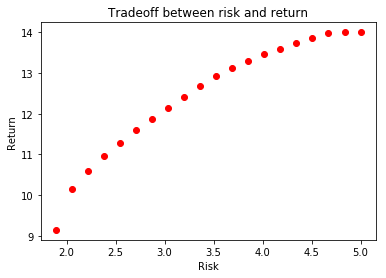

In [15]:
sigmaList=np.linspace(1.893,5,20)
retList=[]
for sigma in sigmaList:
    riskConstraint.QCRHS=sigma**2
    mod2.optimize()
    retList.append(ret.getValue())
import matplotlib.pyplot as plt
plt.plot(sigmaList,retList,'ro')
plt.title('Tradeoff between risk and return')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

### (Optional) 4.1 Exercise

Analyze the tradeoff between return and risk ($\sigma_{target}$), as well as return and change in portfolio ($\Delta$) in the problem for Trojan investment.

#### 4.1.1 Tradeoff between return and risk

Minimum total std: 0.15926921686108744


Maximum return: 0.3145448532023129
Corresponding total std: 1.257137907894366


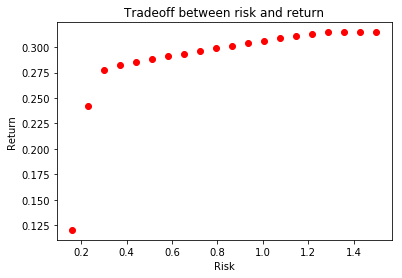

#### 4.1.2 Tradeoff between return and transaction cost

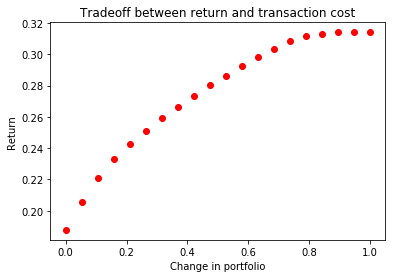